# Классификация стиля вождения

Требуется классифицировать стиль вождения для данных транспортных средств (ТС). Предполагается наличие трех классов стиля вождения:
1. безопасный
2. умеренно опасный
3. опасный

## Препроцессинг данных

Для определения стиля вождения были выбраны следующие параметры:
1. Скорость движения (км/ч) - резкие скачки скорости указывают на резкий, опасный стиль вождения.
2. Телематические данные о высоте над уровнем моря (м) - резкие изменения положения транспортного средства в пространстве указывают на непредсказуемый и опасный выбор траектории движения.
3. Скорость вращения вала двигателя (обороты/с) - резкие изменения показателя оборотов двигателя указывают на спонтанное переключение передач ТС, что также указывает на неаккуратное вождение.

Для начала форматируем данные в удобную для обработки форму.

In [1]:
import os
import pandas as pd

In [2]:
# get all files with vehicle word in name
filenames = [filename for filename in os.listdir('./vehicle_dataset_public/') if filename.find('vehicle') != -1]

In [3]:
def get_unique_vehicles_sensors(filenames):
    vehicles, sensors = set(), set()
    for filename in filenames:
        vehicle_name, sensor_type, _ = filename.split('_')
        vehicles.add(vehicle_name)
        sensors.add(sensor_type)
    return list(vehicles), list(sensors)

In [4]:
vehicles, sensors = get_unique_vehicles_sensors(filenames)

In [5]:
# sort vehicle names and sensor types
vehicles.sort()
sensors.sort()

In [6]:
vehicles_data = pd.Series()
for vehicle_name in vehicles:
    vehicle = pd.Series()
    for sensor in sensors:
        sensor_df = pd.read_csv('./vehicle_dataset_public/'+'_'.join([vehicle_name, sensor, 'public.csv']), sep=';')
        vehicle[sensor] = sensor_df
    vehicles_data[vehicle_name] = vehicle

C:\Users\User\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  """Entry point for launching an IPython kernel.
C:\Users\User\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  This is separate from the ipykernel package so we can avoid doing imports until




Реализуем функции для приведение типов данных в датасете:

In [7]:
def convert_number(num_as_string):
    """
        function converts numbers from string format N,n (replace all commas with dots) 
        to pandas Series float value format N.n (real number)
    """

    return num_as_string.str.replace(',', '.').astype('float')


def convert_date(date_as_string):
    """
        function converts date from string to datetime64 pandas date format
    """
    
    return date_as_string.astype('datetime64')


# replace commas with dots and change type from object to float64
for vehicle in vehicles:
    # fuelLevel dataset preproccess
    for sensor in sensors:
        sensor_data = vehicles_data[vehicle][sensor]
        values = sensor_data.columns
        for value in values:
            # three types: int | float | date
            # need to become: int->int str->float (if BEVALUE) and not int64 already
            # check correctness using print(vehicle, sensor, sensor_data, value)
            if sensor_data[value].dtype == 'object':
                date_like_columns = ['DTIME', 'STARTDATE', 'ENDDATE']
                if value in date_like_columns:
                    sensor_data[value] = convert_date(sensor_data[value])
                else:
                    sensor_data[value] = convert_number(sensor_data[value])
            # if not object do nothing (cause int64 -> (goes to) int64 by default)

In [8]:
# make dataframe with new features
vehicles_df = pd.DataFrame()
for vehicle in vehicles:
    # get only features generated by us
    generated_features = list(set(vehicles_data[vehicle].index) - set(sensors))
    vehicles_df[vehicle] = vehicles_data[vehicle][generated_features]

In [9]:
from matplotlib import pyplot as plt 

Удаляем из набора нереалистичные данные:

In [10]:
#delete imposible values from speed seria
vehicles_data['vehicle3'].speedAndHeight[6041:6043].SPEED = 0
vehicles_data['vehicle3'].speedAndHeight[6041:6043]

C:\Users\User\Anaconda3\lib\site-packages\pandas\core\generic.py:5303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


,DTIME,SPEED,HEIGHT
6041,2020-03-26 08:56:10,0,48.5
6042,2020-03-26 08:56:25,0,26.9


Округляем значения времени до минут:

In [11]:
#round datatime values to minute
for vehicle in vehicles:
    vehicles_data[vehicle].speedAndHeight.DTIME = vehicles_data[vehicle].speedAndHeight.DTIME.dt.round('T')
    vehicles_data[vehicle].tachometer.DTIME = vehicles_data[vehicle].tachometer.DTIME.dt.round('T')

## Вычисление признаков

Для последующей классификации ТС по стилю вождения вычисляем скачки скорости и резкие изменения показателей высоты над уровнем моря и оборотов двигателя. Вычисления производятся методом плавающего окна. Ширина и шаг окна определяются эмпирическим методом.

In [13]:
import numpy as np

C:\Users\User\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  


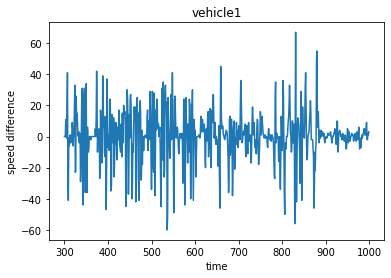

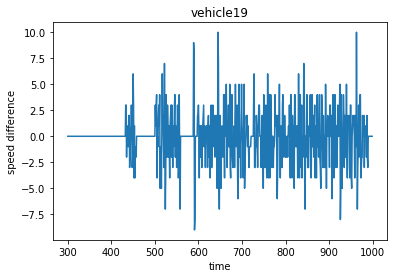

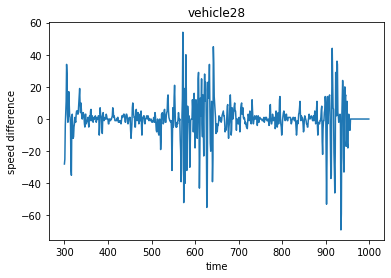

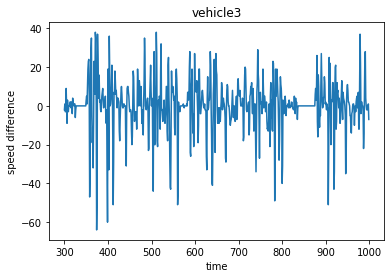

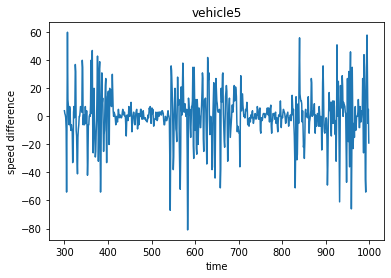

In [14]:
# sliding window for speed
vehicles_data_speed_dif = pd.Series()
w_length = 2  # running classifier: window length (sec)
w_step = 1  # running classifier: window step  (sec)
 

for vehicle in vehicles:
    current_vehicle = vehicles_data[vehicle]
    current_speed_list = current_vehicle.speedAndHeight.SPEED
    w_start = np.arange(0, len(current_speed_list) - w_length, w_step) 
    vehicles_data_speed_dif[vehicle] = scores_windows = []
    
    for n in w_start:
        vehicles_data_speed_dif[vehicle].append(current_speed_list[n + w_length] - current_speed_list[n])
        
    plt.figure()
    plt.plot(w_start[300:1000], vehicles_data_speed_dif[vehicle][300:1000])
    plt.xlabel('time')
    plt.ylabel('speed difference')
    plt.title(vehicle)
    plt.show()
    

Для окна в 2 секунды (выбранное время прироста скорости) за "резкие" скачки скорости принимаются значения прироста скорости от 30 км/час для "умеренно-опасного" стиля вождения и от 40 км/ч для "опасного" стиля вождения.

C:\Users\User\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  


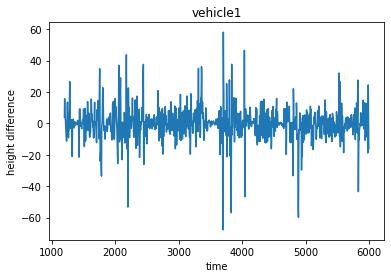

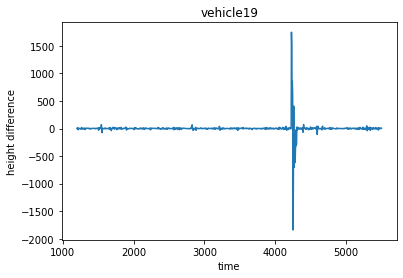

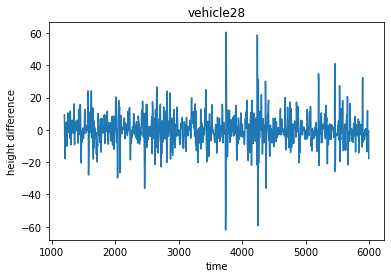

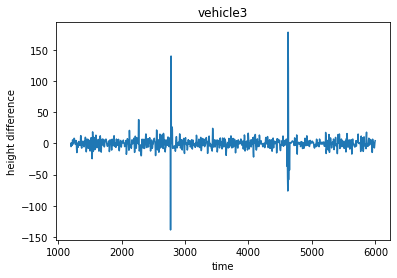

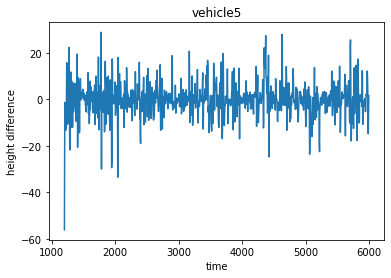

In [19]:
# sliding window for height
vehicles_data_height_dif = pd.Series()
w_length = 8  # window length (sec)
w_step = 4  # window step  (sec)
 

for vehicle in vehicles:
    current_vehicle = vehicles_data[vehicle]
    current_height_list = current_vehicle.speedAndHeight.HEIGHT
    w_start = np.arange(0, len(current_height_list) - w_length, w_step) 
    vehicles_data_height_dif[vehicle] = scores_windows = []
    
    for n in w_start:
        vehicles_data_height_dif[vehicle].append(current_height_list[n + w_length] - current_height_list[n])
        
    plt.figure()
    plt.plot(w_start[300:1500], vehicles_data_height_dif[vehicle][300:1500])
    plt.xlabel('time')
    plt.ylabel('height difference')
    plt.title(vehicle)
    plt.show()
    

Для вычисления изменения показателя высоты над уровнем моря была выбрана ширина окна в 8 секунд. За "резкие" подъемы и спуски принимаются значения прироста высоты от 20 м для "умеренно-опасного" стиля вождения и от 35 м для "опасного" стиля вождения.

C:\Users\User\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  


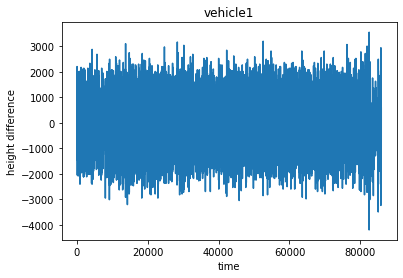

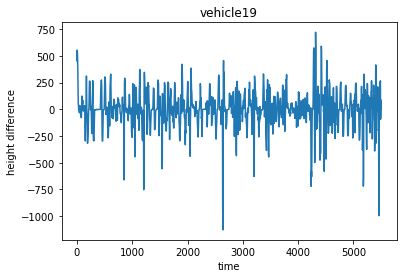

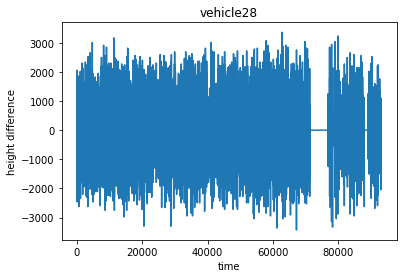

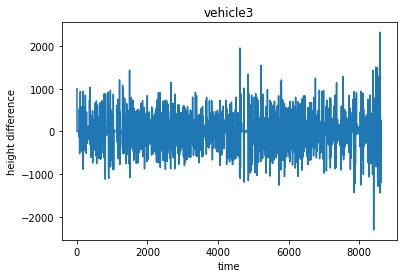

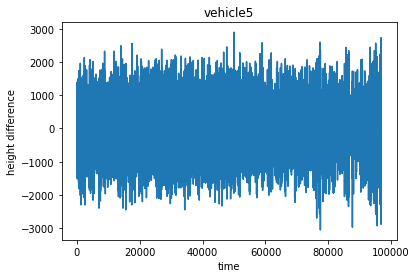

In [21]:
# sliding window for tachometer
vehicles_data_tachometer_dif = pd.Series()
w_length = 8  # window length (sec)
w_step = 4  # window step  (sec)
 

for vehicle in vehicles:
    current_vehicle = vehicles_data[vehicle]
    current_tachometer_list = current_vehicle.tachometer.BEVALUE
    w_start = np.arange(0, len(current_tachometer_list) - w_length, w_step) 
    vehicles_data_tachometer_dif[vehicle] = scores_windows = []
    
    for n in w_start:
        vehicles_data_tachometer_dif[vehicle].append(current_tachometer_list[n + w_length] - current_tachometer_list[n])
        
    plt.figure()
    plt.plot(w_start, vehicles_data_tachometer_dif[vehicle])
    plt.xlabel('time')
    plt.ylabel('height difference')
    plt.title(vehicle)
    plt.show()

Для вычисления изменения показателя скорости оборотов двигателя была выбрана ширина окна в 4 секунды. За "резкую" смену режима вождения принимаются значения прироста сокрости оборотов от 2000 оборотов/сек для "умеренно-опасного" стиля вождения и от 2800 оборотов/сек для "опасного" стиля вождения.

# Классификация стиля вождения методом k-ближайших соседей

Метод k-ближайших соседей реализован в скрипте knn.py